# PV3 Heat Dynamics Identification for the cartridges

## Identification on the data from Februray 9th, 2024

In [1]:
%matplotlib widget
import matplotlib.pyplot as plt

import re
import numpy as np
import control as ctrl

from utils import lsq, sim_arx, read_pv3_heatdata_txt, interpolate_with_latch

The Vacuum press mold is heated by heating cartridge placed inside an aluminum bloc. The mold is placed right above this aluminum bloc. The temperature of the mold is measured at a single point at the interface between the brass mold and the aluminum.
The goal of this notebook is to identify the relationship between the input of the cartridges and the measured temperature of the cartridges.

It is supposed that this relationship can either be modeled by a first or second order system.

### Cartridges behaviour analysis

In [2]:
# Reading the data from the PV3 files
# file_path = "data/experimental/24_02_09/heatData/Bottom Heat Controller worker.txt"
# cart_state_file_path = "data/experimental/24_02_09/heatData/state_Bottom Heat Controller worker.txt"
file_path = "data/experimental/24_02_09/18_33_00/heatData/"
temp_filename = "Bottom Heat Controller worker.txt"
cart_state_filename = "state_Bottom Heat Controller worker.txt"

data_temp_bot, headers_temp = read_pv3_heatdata_txt(file_path + temp_filename)
data_state_bot, headers_state = read_pv3_heatdata_txt(file_path + cart_state_filename)

t_temp = (data_temp_bot['Time'] - data_temp_bot['Time'][0]) / 1e3 # conversion to seconds 
t_state = (data_state_bot['Time'] - data_state_bot['Time'][0]) / 1e9 # conversion to seconds 
desired_out_temp_raw = np.array(data_temp_bot['Target'])
out_temp_raw = np.array(data_temp_bot['Stack'])

ct_names = ["CT_" + str(i//4+1) + str((i%4) + 1) for i in range(16)]

ct_temp_raw = []
for i in range(16):
    ct_temp_raw.append(data_temp_bot[ct_names[i]])
ct_temp_raw = np.array(ct_temp_raw)

ct_state_raw = []
for i in range(16):
    ct_state_raw.append(data_state_bot[ct_names[i]])
ct_state_raw = np.array(ct_state_raw)

# same data reading for the upper stack
temp_filename = "Top Heat Controller worker.txt"
cart_state_filename = "state_Top Heat Controller worker.txt"

data_temp_top, headers_temp = read_pv3_heatdata_txt(file_path + temp_filename)
data_state_top, headers_state = read_pv3_heatdata_txt(file_path + cart_state_filename)

t_temp_top = (data_temp_top['Time'] - data_temp_top['Time'][0]) / 1e3 # conversion to seconds 
t_state_top = (data_state_top['Time'] - data_state_top['Time'][0]) / 1e9 # conversion to seconds 
out_temp_top_raw = np.array(data_temp_top['Stack'])

ct_temp_top_raw = []
for i in range(16):
    ct_temp_top_raw.append(data_temp_top[ct_names[i]])
ct_temp_top_raw = np.array(ct_temp_top_raw)

ct_state_top_raw = []
for i in range(16):
    ct_state_top_raw.append(data_state_top[ct_names[i]])
ct_state_top_raw = np.array(ct_state_top_raw)

In [3]:
# plot newly interpolated data 
t0 = np.max([t_temp[0], t_state[0], t_temp_top[0], t_state_top[0]])
t1 = np.min([t_temp[-1], t_state[-1], t_temp_top[-1], t_state_top[-1]])
dt = 2e-1 # 200 ms
t = np.arange(t0,t1,dt)

out_temp_bot = np.interp(t, t_temp, out_temp_raw)
out_temp_top = np.interp(t, t_temp_top, out_temp_top_raw)

ct_temp_bot = np.zeros((ct_temp_raw.shape[0], len(t)))
for i, ct in enumerate(ct_temp_raw):
    ct_temp_bot[i,:] = np.interp(t, t_temp, ct)
ct_temp_top = np.zeros((ct_temp_top_raw.shape[0], len(t)))
for i, ct in enumerate(ct_temp_top_raw):
    ct_temp_top[i,:] = np.interp(t, t_temp_top, ct)

ct_state_bot = np.zeros((ct_state_raw.shape[0], len(t)))
for i, ct in enumerate(ct_state_raw):
    ct_state_bot[i,:] = interpolate_with_latch(t, t_state_top, ct)
ct_state_top = np.zeros((ct_state_top_raw.shape[0], len(t)))
for i, ct in enumerate(ct_state_top_raw):
    ct_state_top[i,:] = interpolate_with_latch(t, t_state_top, ct)

Text(0.5, 1.0, 'Bottom stack')

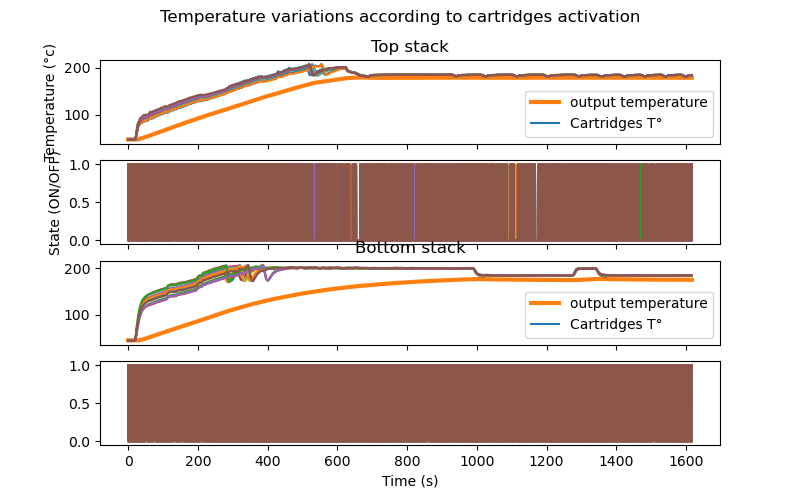

In [4]:
# Plotting the data
color_list = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

fig, ax = plt.subplots(4, 1, sharex=True, figsize=(8, 5)) #
labels = []
ax[3].set_xlabel('Time (s)') 
ax[0].set_ylabel('Temperature (°c)')
ax[1].set_ylabel('State (ON/OFF)')

labels = []

fig.suptitle("Temperature variations according to cartridges activation")
ax[0].plot(t, out_temp_top, color=color_list[1], linewidth=3, label='output temperature')
for i in range(16):
    if 'cart_top' in labels:
        ax[0].plot(t, ct_temp_top[i], color=color_list[i % 10])
    else:
        labels.append('cart_top')
        ax[0].plot(t, ct_temp_top[i], color=color_list[i % 10], label="Cartridges T°")
    if 'cart_top_in' in labels:
        ax[1].plot(t, ct_state_top[i], color=color_list[i % 10])
    else:
        labels.append('cart_top_in')
        ax[1].plot(t, ct_state_top[i], color=color_list[i % 10], label="Cartridges state")
ax[0].legend()
ax[0].set_title("Top stack")

ax[2].plot(t, out_temp_bot, color=color_list[1], linewidth=3, label='output temperature')
for i in range(16):
    if 'cart_bot' in labels:
        ax[2].plot(t, ct_temp_bot[i], color=color_list[i % 10])
    else:
        labels.append('cart_bot')
        ax[2].plot(t, ct_temp_bot[i], color=color_list[i % 10], label="Cartridges T°")
    if 'cart_bot_in' in labels:
        ax[3].plot(t, ct_state_bot[i], color=color_list[i % 10])
    else:
        labels.append('cart_bot_in')
        ax[3].plot(t, ct_state_bot[i], color=color_list[i % 10], label="Cartridges state")
ax[2].legend()
ax[2].set_title("Bottom stack")

During the first 280sec, the top stack target temperature raised from 47.89 to 111.37.
The bottom stack target temperature raised from 44.94 to 106.70.


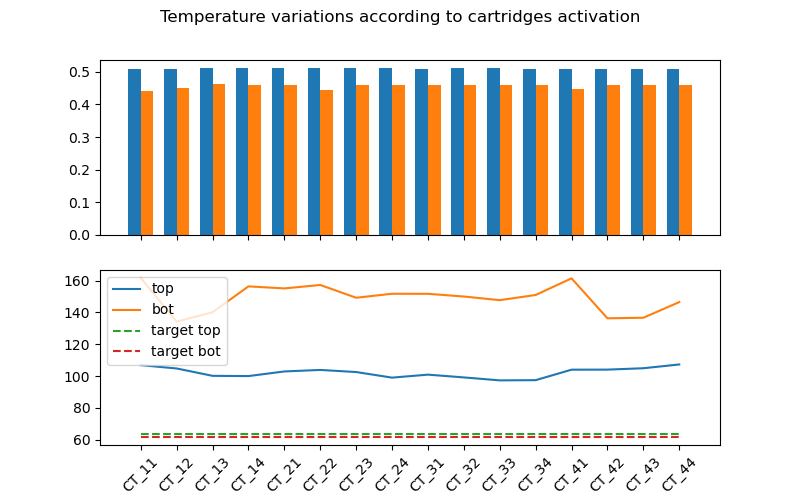

In [5]:
# Computing the time on/off ratio for each cartridge rising phase
# time between 0s and 280s
idx = int(280/dt)
top_rate = np.sum(ct_state_top[:,0:idx], axis=1)/idx
bot_rate = np.sum(ct_state_bot[:,0:idx], axis=1)/idx
top_temp_raise = ct_temp_top[:,idx] - ct_temp_top[:,0]
bot_temp_raise = ct_temp_bot[:,idx] - ct_temp_bot[:,0]
top_target_temp_raise = out_temp_top[idx] - out_temp_top[0]
bot_target_temp_raise = out_temp_bot[idx] - out_temp_bot[0]

fig, ax = plt.subplots(2, 1, sharex=True, figsize=(8, 5)) #

x = np.arange(len(ct_names))
width = 0.35

ax[0].bar(x - width/2, top_rate, width, label='top')
ax[0].bar(x + width/2, bot_rate, width, label='bot')

ax[1].plot(x, top_temp_raise, label='top')
ax[1].plot(x, bot_temp_raise, label='bot')
ax[1].plot([x[0], x[-1]], [top_target_temp_raise, top_target_temp_raise], linestyle='dashed', label='target top')
ax[1].plot([x[0], x[-1]], [bot_target_temp_raise, bot_target_temp_raise], linestyle='dashed', label='target bot')

ax[1].set_xticks(x)
ax[1].set_xticklabels(ct_names, rotation=45)
ax[1].legend()

fig.suptitle("Temperature variations according to cartridges activation")

print("During the first 280sec, the top stack target temperature raised from {:.2f} to {:.2f}.\nThe bottom stack target temperature raised from {:.2f} to {:.2f}.".format(
    out_temp_top[0], out_temp_top[idx], out_temp_bot[0], out_temp_bot[idx]))


Text(0, 0.5, 'Time ON (ms)')

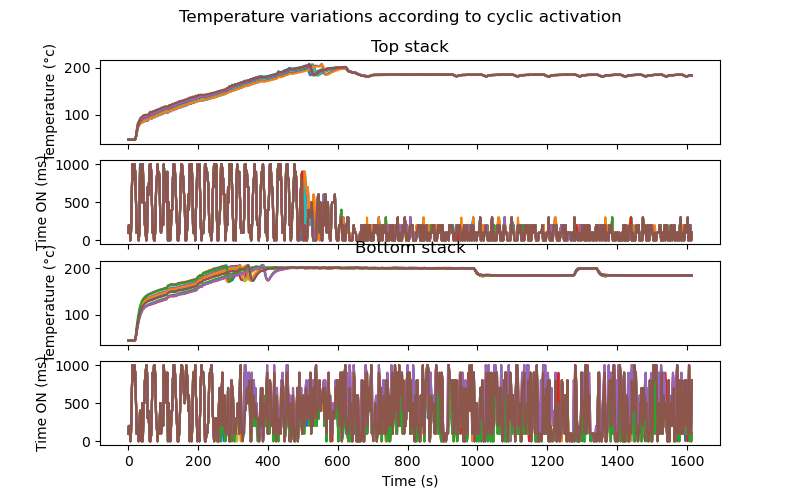

In [6]:
# stack up data by 2s groups 
nb_samples_in_gp = int(2/dt) # 2 seconds
nb_samples_to_ignore = np.mod(ct_state_top.shape[1], 10) # to br able to reshape
ct_state_top_cycle_activation = np.sum(ct_state_top[:,:-nb_samples_to_ignore].reshape(16,-1,nb_samples_in_gp), axis=2)*1e2
ct_state_bot_cycle_activation = np.sum(ct_state_bot[:,:-nb_samples_to_ignore].reshape(16,-1,nb_samples_in_gp), axis=2)*1e2
t_sec = np.arange(ct_state_top_cycle_activation.shape[1])*2

fig, ax = plt.subplots(4, 1, sharex=True, figsize=(8, 5)) #
fig.suptitle("Temperature variations according to cyclic activation")
ax[3].set_xlabel('Time (s)') 

ax[0].plot(t_sec, ct_temp_top[:,0:-nb_samples_to_ignore:nb_samples_in_gp].T)
ax[1].plot(t_sec, ct_state_top_cycle_activation.T)
ax[0].set_title("Top stack")
ax[0].set_ylabel('Temperature (°c)')
ax[1].set_ylabel('Time ON (ms)')

ax[2].plot(t_sec, ct_temp_bot[:,0:-nb_samples_to_ignore:nb_samples_in_gp].T)
ax[3].plot(t_sec, ct_state_bot_cycle_activation.T)
ax[2].set_title("Bottom stack")
ax[2].set_ylabel('Temperature (°c)')
ax[3].set_ylabel('Time ON (ms)')


### Cartridges identification

Let's dive in to a random cartridges from the bottom stack to identify its behaviour.

In [7]:
import control as ctrl

Let's try the identification using the cyclic activation time as input.

Text(0.5, 1.0, 'CT_33')

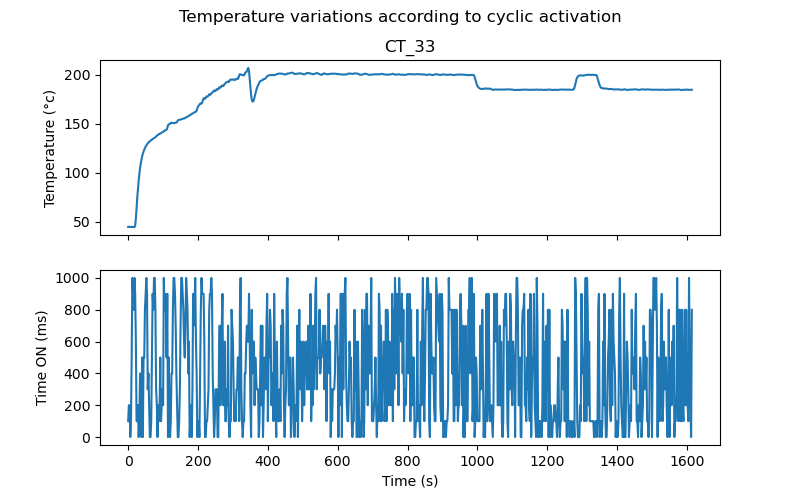

In [8]:
N_ct = 10 # select a cartridge

u = ct_state_bot_cycle_activation[N_ct,:]
y = ct_temp_bot[N_ct,0:-nb_samples_to_ignore:nb_samples_in_gp]

fig, ax = plt.subplots(2, 1, sharex=True, figsize=(8, 5)) #
fig.suptitle("Temperature variations according to cyclic activation")
ax[1].set_xlabel('Time (s)') 
ax[0].plot(t_sec, y)
ax[1].plot(t_sec, u)
ax[0].set_ylabel('Temperature (°c)')
ax[1].set_ylabel('Time ON (ms)')
ax[0].set_title(ct_names[N_ct])


In [9]:
# identification with least square
# y = theta @ [a1,...,an, b1, ..., bn]
na = 2 # input coeff of numerator order + 1
nb = 3 # output coeff of denominator order + 1
u0 = u[0]
y0 = y[0]
a_coeff, b_coeff, mse = lsq(na, nb, u=u-u0, y=y-y0, y_init=np.zeros((nb-1,1)))
sysd = ctrl.TransferFunction(a_coeff, np.insert(b_coeff, 0, 1), dt)
#
# a0 = a_coeff[1]
# a1 = a_coeff[0]
# b0 = b_coeff[1]
# b1 = b_coeff[0]
sysd

TransferFunction(array([2.71206233e-06, 4.84617025e-05]), array([ 1.       , -1.8879906,  0.8880933]), 0.2)

In [10]:
_, y_sim = ctrl.forced_response(sysd, t_sec, u)

Text(0.5, 1.0, 'Temperature identification')

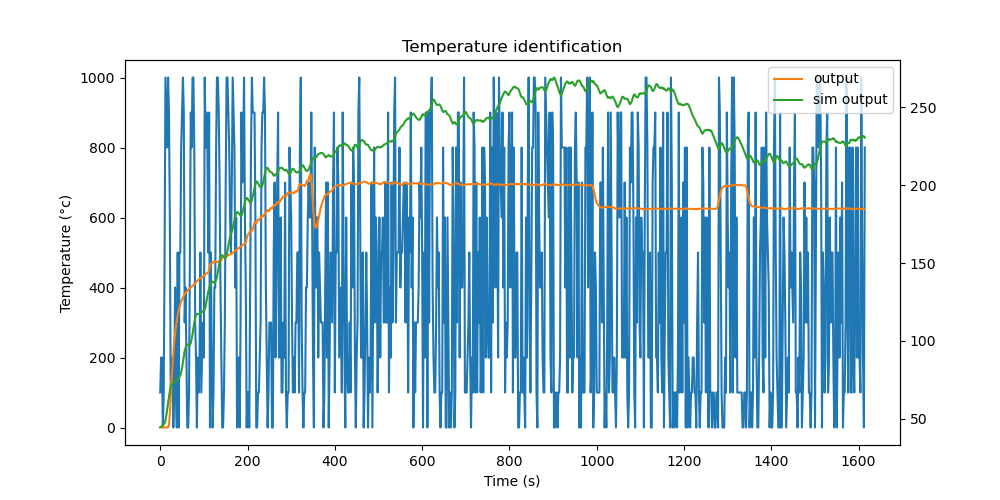

In [11]:
# Plotting the data
_, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.set_xlabel('Time (s)') 
ax.set_ylabel('Temperature (°c)')
ax2 = ax.twinx()

ax.plot(t_sec, u, color=color_list[0], label='input')
ax2.plot(t_sec, y, color=color_list[1], label='output')
ax2.plot(t_sec, y_sim+y0, color=color_list[2], label='sim output')

# ax.legend()
ax2.legend()
ax.set_title('Temperature identification')

The identification using the cyclic activation time seems unconclusive. Let's try using the binary PWM like input.

In [12]:
idx_identif = np.arange(0,5000)
u_id = ct_state_bot[N_ct,idx_identif]
y_id = ct_temp_bot[N_ct,idx_identif]
u0 = u[0]
y0 = y[0]
a_coeff, b_coeff, mse = lsq(na, nb, u=u_id-u0, y=y_id-y0, y_init=np.zeros((nb-1,1)))
sysd_2 = ctrl.TransferFunction(a_coeff, np.insert(b_coeff, 0, 1), dt)
sysd_2

TransferFunction(array([ 1.78009254e-05, -8.93202999e-05]), array([ 1.        , -1.98549378,  0.98554206]), 0.2)

In [13]:
u_sim = ct_state_bot[N_ct,:]
y = ct_temp_bot[N_ct,:]
_, y_sim_2 = ctrl.forced_response(sysd_2, t, u_sim)

# Plotting the data
_, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.set_xlabel('Time (s)') 
ax.set_ylabel('Temperature (°c)')
ax2 = ax.twinx()

ax.plot(t, u_sim, color=color_list[0], label='input')
ax2.plot(t, y, color=color_list[1], label='output')
ax2.plot(t, y_sim_2+y0, color=color_list[2], label='sim output')

# ax.legend()
ax2.legend()
ax.set_title('Temperature identification')

Text(0.5, 1.0, 'Temperature identification')

The identification using the binary input signal of the cartridges also seems unconclusive. 
The cartridges might be related to other variables. In fact, the cartridges temperature is influenced by the energy injected in the system, minus the thermic diffusion.
The energy is directly proportional to the cyclic time activation, in the case of constant power. The power of the cartridges is given by Ohm's law.
$$ P(t) = R i(t)^2 $$
Therefore, variations of current $i$ will provoke variation of power. This could explain why the input data is insufficient.

## Identification on the data from Februray 19th, 2024

Another simplified solution for the identification would be to activate single cartridges with step input. This was done with the data from February, 19th.

In [14]:
# Reading the data from the PV3 files
# file_path = "data/experimental/24_02_09/heatData/Bottom Heat Controller worker.txt"
# cart_state_file_path = "data/experimental/24_02_09/heatData/state_Bottom Heat Controller worker.txt"
file_path = "data/experimental/24_02_19/14_07_45/heatData/"
temp_filename = "Bottom Heat Controller worker.txt"

data_temp_bot, headers_temp = read_pv3_heatdata_txt(file_path + temp_filename)

t_temp = (data_temp_bot['Time'] - data_temp_bot['Time'][0]) / 1e3 # conversion to seconds 
out_temp_raw = np.array(data_temp_bot['Stack'])

ct_temp_raw = []
for i in range(16):
    ct_temp_raw.append(data_temp_bot[ct_names[i]])
ct_temp_raw = np.array(ct_temp_raw)

In [15]:
# 
CT_11_step_response_raw = ct_temp_raw[0,50:250]
t_CT_11_raw = t_temp[50:250]
CT_11_init_val = np.mean(CT_11_step_response_raw[:35])
CT_11_input_raw = np.zeros(CT_11_step_response_raw.shape)
CT_11_input_raw[39:114] = 1
CT_44_step_response_raw = ct_temp_raw[-1,234:-1]
t_CT_44_raw = t_temp[234:-1]
CT_44_init_val = np.mean(CT_44_step_response_raw[:35])
CT_44_input_raw = np.zeros(CT_44_step_response_raw.shape)
CT_44_input_raw[36:103] = 1

In [16]:
fig, ax = plt.subplots(2, 1, figsize=(8, 5)) #
fig.suptitle("Cartridges temperature variations")
ax[1].set_xlabel('Time (s)') 
ax[0].set_ylabel('Temperature (°c)') 
ax[1].set_ylabel('Temperature (°c)') 

ax[0].plot(t_CT_11_raw, CT_11_step_response_raw - CT_11_init_val, '-x')
ax2 = ax[0].twinx()
ax2.plot(t_CT_11_raw, CT_11_input_raw, color=color_list[1])
ax2.set_ylabel('Input State')
ax[1].plot(t_CT_44_raw, CT_44_step_response_raw - CT_44_init_val, '-x')
ax3 = ax[1].twinx()
ax3.plot(t_CT_44_raw, CT_44_input_raw, color=color_list[1])
ax3.set_ylabel('Input State')

Text(0, 0.5, 'Input State')

In [17]:
# interpolate data for identification
t_CT_11 = np.arange(t_CT_11_raw[0],t_CT_11_raw[-1],dt)
t_CT_44 = np.arange(t_CT_44_raw[0],t_CT_44_raw[-1],dt)

CT_11_step_response = np.interp(t_CT_11, t_CT_11_raw, CT_11_step_response_raw)
CT_11_input = np.interp(t_CT_11, t_CT_11_raw, CT_11_input_raw)
CT_44_step_response = np.interp(t_CT_44, t_CT_44_raw, CT_44_step_response_raw)
CT_44_input = np.interp(t_CT_44, t_CT_44_raw, CT_44_input_raw)


### Identification using ARX least square

In [18]:
# identification with least square
# y = theta @ [a1,...,an, b1, ..., bn]
na = 2 # input coeff of numerator order + 1
nb = 3 # output coeff of denominator order + 1
a_coeff, b_coeff, mse = lsq(na, nb, u=CT_11_input, y=CT_11_step_response-CT_11_init_val, y_init=np.zeros((nb-1,1)))
sys_CT_11 = ctrl.TransferFunction(a_coeff, np.insert(b_coeff, 0, 1), dt)
a_coeff, b_coeff, mse = lsq(na, nb, u=CT_44_input, y=CT_44_step_response-CT_44_init_val, y_init=np.zeros((nb-1,1)))
sys_CT_44 = ctrl.TransferFunction(a_coeff, np.insert(b_coeff, 0, 1), dt)

In [19]:
# identified system simulated response
t_CT_11_sim, CT_11_step_sim_response = ctrl.forced_response(sys_CT_11, U=CT_11_input)
t_CT_44_sim, CT_44_step_sim_response = ctrl.forced_response(sys_CT_44, U=CT_44_input)

In [20]:
fig, ax = plt.subplots(2, 1, figsize=(8, 5)) #
fig.suptitle("Cartridges temperature variations")
ax[1].set_xlabel('Time (s)') 
ax[0].set_ylabel('Temperature (°c)') 
ax[1].set_ylabel('Temperature (°c)') 

ax[0].plot(t_CT_11-t_CT_11[0], CT_11_step_response - CT_11_init_val, '-x')
ax[0].plot(t_CT_11_sim, CT_11_step_sim_response, color=color_list[3])
ax2 = ax[0].twinx()
ax2.plot(t_CT_11-t_CT_11[0], CT_11_input, color=color_list[1])
ax2.set_ylabel('Input State')
ax[1].plot(t_CT_44-t_CT_44[0], CT_44_step_response - CT_44_init_val, '-x')
ax[1].plot(t_CT_44_sim, CT_44_step_sim_response, color=color_list[3])
ax3 = ax[1].twinx()
ax3.plot(t_CT_44-t_CT_44[0], CT_44_input, color=color_list[1])
ax3.set_ylabel('Input State')

Text(0, 0.5, 'Input State')

In [21]:
sys_CT_11

TransferFunction(array([ 1.03011206, -0.90519919]), array([ 1.        , -1.94482017,  0.94551004]), 0.2)

In [22]:
sys_CT_44

TransferFunction(array([-0.61753374,  0.97224794]), array([ 1.        , -1.86775722,  0.87004812]), 0.2)

### Identification of 1st order continuous system

The system identification can also be done in a continuous form, to then discretize the system identified using a zero order hold.

For a first order system, we want to identify the gain $K$ and the time constant $\tau$ of the form:
$$ H(s) = \frac{K}{1 + \tau s}$$ 
$K$ is easily identified using the steady state value to a unitary input, while the time constant $\tau$ can be obtained knowing that it is reached when 63% of the steady state value is obtained in the step response, or for more precision, 95% of the steady state response is equivalent to $3\tau$.

In [23]:
idx_steady = (t_CT_11 >= 251) == (t_CT_11 <= 260)
steady_state_value_CT_11 = np.mean(CT_11_step_response[idx_steady]) - CT_11_init_val 
idx_steady = np.argmax(t_CT_44 > 538)
steady_state_value_CT_44 = CT_44_step_response[idx_steady] - CT_44_init_val
# Since the input is 1, the steady state value is the gain K

t_start_CT_11 = t_CT_11[np.argmax(CT_11_input > 0)] - dt
t_start_CT_44 = t_CT_44[np.argmax(CT_44_input > 0)] - dt

t_CT_11_063 = t_CT_11[np.argmax(CT_11_step_response >= 0.63*steady_state_value_CT_11)]
t_CT_11_095 = t_CT_11[np.argmax(CT_11_step_response >= 0.95*steady_state_value_CT_11)]
t_CT_44_063 = t_CT_44[np.argmax(CT_44_step_response >= 0.63*steady_state_value_CT_44)]
t_CT_44_095 = t_CT_44[np.argmax(CT_44_step_response >= 0.95*steady_state_value_CT_44)]

print(t_CT_11_063-t_start_CT_11)
print((t_CT_11_095-t_start_CT_11)/3)

print(t_CT_44_063-t_start_CT_44)
print((t_CT_44_095-t_start_CT_44)/3)

7.200000000000074
4.800000000000058
6.7999999999996135
4.0666666666664355


In [24]:
# CT_11 1st order models according to the identification methods
K_CT_11 = steady_state_value_CT_11
tau_CT_11_063 = t_CT_11_063-t_start_CT_11
sys_CT_11_01 = ctrl.tf([K_CT_11], [tau_CT_11_063, 1])
tau_CT_11_095 = (t_CT_11_095-t_start_CT_11)/3
sys_CT_11_02 = ctrl.tf([K_CT_11], [tau_CT_11_095, 1])
# CT_44 1st order models according to the identification methods
K_CT_44 = steady_state_value_CT_44
tau_CT_44_063 = t_CT_44_063-t_start_CT_44
sys_CT_44_01 = ctrl.tf([K_CT_44], [tau_CT_44_063, 1])
tau_CT_44_095 = (t_CT_44_095-t_start_CT_44)/3
sys_CT_44_02 = ctrl.tf([K_CT_44], [tau_CT_44_095, 1])

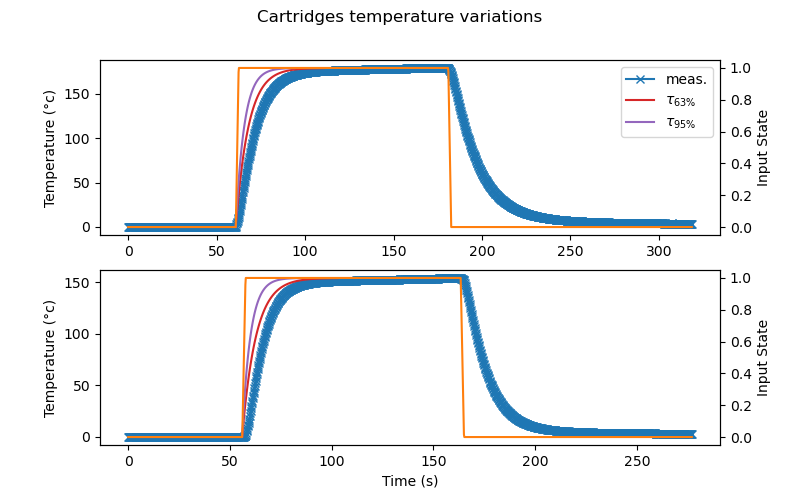

In [25]:
# Comparison of the continuous responses
t_CT_11_sim_01, y_CT_11_sim_01 = ctrl.step_response(sys_CT_11_01)
t_CT_11_sim_02, y_CT_11_sim_02 = ctrl.step_response(sys_CT_11_02)
t_CT_44_sim_01, y_CT_44_sim_01 = ctrl.step_response(sys_CT_44_01)
t_CT_44_sim_02, y_CT_44_sim_02 = ctrl.step_response(sys_CT_44_02)

fig, ax = plt.subplots(2, 1, figsize=(8, 5)) #
fig.suptitle("Cartridges temperature variations")
ax[1].set_xlabel('Time (s)') 
ax[0].set_ylabel('Temperature (°c)') 
ax[1].set_ylabel('Temperature (°c)') 

ax[0].plot(t_CT_11-t_CT_11[0], CT_11_step_response - CT_11_init_val, '-x', label='meas.')
ax[0].plot(t_CT_11_sim_01+t_start_CT_11-t_CT_11[0], y_CT_11_sim_01, color=color_list[3], label=r'$\tau_{63\%}$')
ax[0].plot(t_CT_11_sim_02+t_start_CT_11-t_CT_11[0], y_CT_11_sim_02, color=color_list[4], label=r'$\tau_{95\%}$')
ax2 = ax[0].twinx()
ax2.plot(t_CT_11-t_CT_11[0], CT_11_input, color=color_list[1])
ax2.set_ylabel('Input State')
ax[1].plot(t_CT_44-t_CT_44[0], CT_44_step_response - CT_44_init_val, '-x', label='meas.')
ax[1].plot(t_CT_44_sim_01+t_start_CT_44-t_CT_44[0], y_CT_44_sim_01, color=color_list[3], label=r'$\tau_{63\%}$')
ax[1].plot(t_CT_44_sim_02+t_start_CT_44-t_CT_44[0], y_CT_44_sim_02, color=color_list[4], label=r'$\tau_{95\%}$')
ax3 = ax[1].twinx()
ax3.plot(t_CT_44-t_CT_44[0], CT_44_input, color=color_list[1])
ax3.set_ylabel('Input State')
ax[0].legend()

### 2nd order continuous system

It can easily be seen that the initial derivative is nul for the cartridges step responses, which is not compatible with a first order system, we can therefore try to identify a second order system, with a damped step response. We can as a first approximation consider a damping ratio $\xi$ that corresponds to a critically damped system, that is $\xi=1$.
$$ H(s) = \frac{K}{1 + \frac{2\xi}{\omega_0}s + \frac{1}{\omega_0^2}s^2}$$

In [26]:
xi_CT_11_01 = 1
w0_CT_11_01 = 4 / (3*tau_CT_11_063)
sys2_CT_11_01 = ctrl.tf([K_CT_11], [1/w0_CT_11_01**2, 2*xi_CT_11_01/w0_CT_11_01, 1])

xi_CT_44_01 = 1
w0_CT_44_01 = 4 / (3*tau_CT_44_063)
sys2_CT_44_01 = ctrl.tf([K_CT_44], [1/w0_CT_44_01**2, 2*xi_CT_44_01/w0_CT_44_01, 1])

In [27]:
# Comparison of the continuous responses
t_CT_11_sim2_01, y_CT_11_sim2_01 = ctrl.step_response(sys2_CT_11_01, T=100)
t_CT_44_sim2_01, y_CT_44_sim2_01 = ctrl.step_response(sys2_CT_44_01, T=100)

fig, ax = plt.subplots(2, 1, figsize=(8, 5)) #
fig.suptitle("Cartridges temperature variations")
ax[1].set_xlabel('Time (s)') 
ax[0].set_ylabel('Temperature (°c)') 
ax[1].set_ylabel('Temperature (°c)') 

ax[0].plot(t_CT_11-t_CT_11[0], CT_11_step_response - CT_11_init_val, '-x', label='meas.')
ax[0].plot(t_CT_11_sim2_01+t_start_CT_11-t_CT_11[0], y_CT_11_sim2_01, color=color_list[3], label=r'$\tau_{63\%}$')
ax2 = ax[0].twinx()
ax2.plot(t_CT_11-t_CT_11[0], CT_11_input, color=color_list[1])
ax2.set_ylabel('Input State')
ax[1].plot(t_CT_44-t_CT_44[0], CT_44_step_response - CT_44_init_val, '-x', label='meas.')
ax[1].plot(t_CT_44_sim2_01+t_start_CT_44-t_CT_44[0], y_CT_44_sim2_01, color=color_list[3], label=r'$\tau_{63\%}$')
ax3 = ax[1].twinx()
ax3.plot(t_CT_44-t_CT_44[0], CT_44_input, color=color_list[1])
ax3.set_ylabel('Input State')
ax[0].legend()

This response is clearly more accurate and could still be upgraded by minimizing the quadratic error of the step response, however, as a first approximation we will work with this model.

In [28]:
sys2_CT_11_01

TransferFunction(array([179.20504964]), array([29.16, 10.8 ,  1.  ]))

In [29]:
sys2_CT_44_01

TransferFunction(array([153.95147465]), array([26.01, 10.2 ,  1.  ]))

If we consider now the cyclic time as an input, instead of the binary 1 - 0 value, the transfer function gets divided by the cyclic value.

In [30]:
cyclic_time = 200 # in ms
sys2_CT_11_01_ms = sys2_CT_11_01/cyclic_time
sys2_CT_44_01_ms = sys2_CT_44_01/cyclic_time

To obtained the discretized version of this function, we have to use a zero order hold method, since it is what actualy happens with the system.

In [31]:
sys2d_CT_11_01_ms = ctrl.c2d(sys2_CT_11_01_ms, Ts=dt, method='zoh')
sys2d_CT_44_01_ms = ctrl.c2d(sys2_CT_44_01_ms, Ts=dt, method='zoh')
sys2d_CT_11_01_ms

TransferFunction(array([0.00059959, 0.00058497]), array([ 1.        , -1.92728089,  0.92860291]), 0.2)

In [32]:
# Discretized response added
t_CT_11_sim2d_01_ms, y_CT_11_sim2d_01_ms = ctrl.step_response(cyclic_time*sys2d_CT_11_01_ms, T=100)
t_CT_44_sim2d_01_ms, y_CT_44_sim2d_01_ms = ctrl.step_response(cyclic_time*sys2d_CT_44_01_ms, T=100)

ax[0].plot(t_CT_11_sim2d_01_ms+t_start_CT_11-t_CT_11[0], y_CT_11_sim2d_01_ms, linestyle='dashed',color=color_list[4], label=r'$zoh$')
ax[1].plot(t_CT_44_sim2d_01_ms+t_start_CT_44-t_CT_44[0], y_CT_44_sim2d_01_ms, linestyle='dashed', color=color_list[4], label=r'$zoh$')
ax[0].legend()

### Identification of the top stack cartridges

As shown on the first part of this notebook, the cartridges of the bottom of upper stack have different response characteristics.

In [33]:
# file_path = "data/experimental/24_03_13/14_28_46/heatData/" # this data is sampled around 2s
file_path = "data/experimental/24_03_14/10_59_06/heatData/" # this data is sampled around 200ms
temp_filename = "Top Heat Controller worker.txt"

data_temp_top, headers_temp = read_pv3_heatdata_txt(file_path + temp_filename)

t_temp = (data_temp_top['Time'] - data_temp_top['Time'][0]) / 1e3 # conversion to seconds 
desired_out_temp_raw = np.array(data_temp_top['Target'])
out_temp_raw = np.array(data_temp_top['Stack'])

ct_names = ["CT_" + str(i//4+1) + str((i%4) + 1) for i in range(16)]

ct_temp_raw = []
for i in range(16):
    ct_temp_raw.append(data_temp_top[ct_names[i]])
ct_temp_raw = np.array(ct_temp_raw)

In [90]:
# interpolate the data at a rate of dt
t = np.arange(t_temp[0],t_temp[-1],dt)

desired_out_temp = np.interp(t, t_temp, desired_out_temp_raw)
out_temp = np.interp(t, t_temp, out_temp_raw)
ct_temp = [None]*16
for i in range(16):
    ct_temp[i] = np.interp(t, t_temp, ct_temp_raw[i])
ct_temp = np.array(ct_temp)

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

for i, ct_name in enumerate(ct_names): 
    if i//10 == 0:
        linestyle = '-'
    elif i//10 == 1:
        linestyle = ':'
    else:
        #TODO: error
        pass
    ax.plot(t, ct_temp[i], linestyle, color=color_list[np.mod(i,10)], label=ct_name)
ax.set_xlabel('Time (s)') 
ax.set_ylabel('Temperature (°c)') 
ax.legend()

To get rid of the slow bias du to the temperature variation, let's filter the responses.

Text(0.5, 1.0, 'Filtering the stack temperature variations')

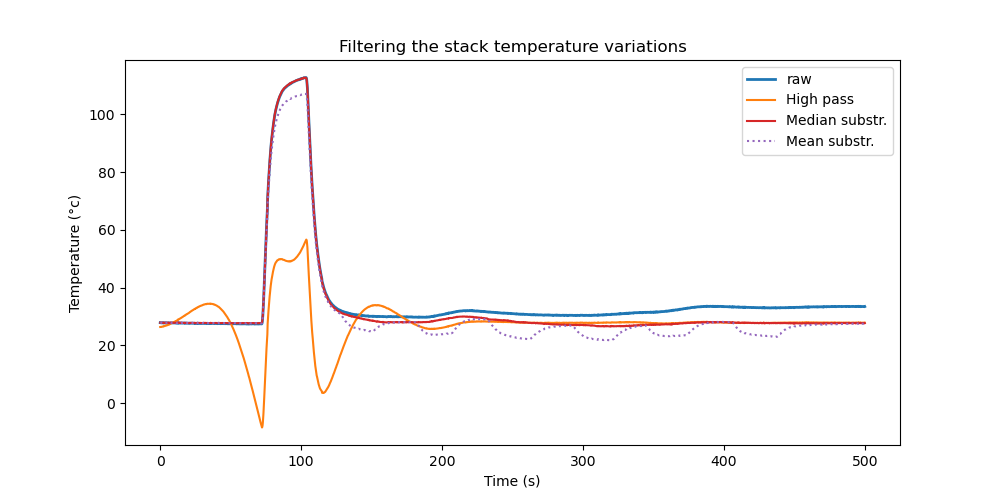

In [36]:
import scipy.signal as sig

cutoff_freq = 0.05 # in Hz
order = 4

b, a = sig.butter(order, cutoff_freq*(0.5*dt), 'high')
ct_11_temp_filt = sig.filtfilt(b, a, ct_temp[0])
cart_med = np.median(ct_temp, axis=0)
cart_avg = np.mean(ct_temp, axis=0)

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(t, ct_temp[0], color=color_list[0], linewidth=2, label='raw')
ax.plot(t, ct_11_temp_filt + ct_temp[0,0], color=color_list[1], label='High pass')
ax.plot(t, ct_temp[0]-cart_med+cart_med[0], color=color_list[3], label='Median substr.')
ax.plot(t, ct_temp[0]-cart_avg+cart_avg[0], ':', color=color_list[4], label='Mean substr.')
ax.set_xlabel('Time (s)') 
ax.set_ylabel('Temperature (°c)') 
ax.legend()
ax.set_title("Filtering the stack temperature variations")

Text(0.5, 1.0, 'Cartilages setpoints')

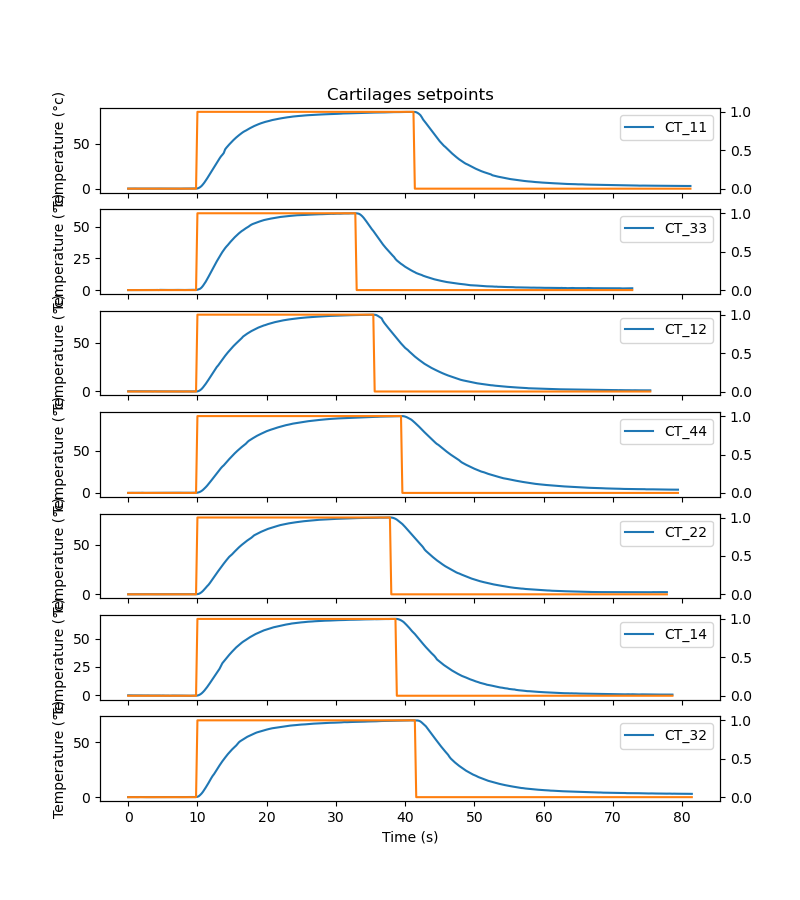

In [37]:
# generating the cartridges setpoints manually
# ct_ton = np.array([154.2, 294.2, 388, 496, 596])
# ct_toff = np.array([236, 366, 468, 564, 668])
ct_ton = np.array([72.1, 127.3, 180.9, 231.7, 291.9, 343.9, 405.5])
ct_toff = np.array([103.6, 150.4, 206.6, 261.4, 320, 372.8, 437.2])
ct_i_on = np.ceil(ct_ton.copy()/dt).astype(int)
ct_i_off = np.ceil(ct_toff.copy()/dt).astype(int)

ct_status = np.zeros((ct_temp.shape))
# ct_edge_names = ["CT_11", "CT_33", "CT_14", "CT_41", "CT_22"]
ct_edge_names = ["CT_11", "CT_33", "CT_12", "CT_44", "CT_22", "CT_14", "CT_32"]
margin = 100

fig, ax = plt.subplots(len(ct_edge_names),1, figsize=(8, 9), sharex=True)
for i, ct_name in enumerate(ct_edge_names):
    cart_i = ct_names.index(ct_name)
    ct_status[cart_i, ct_i_on[i]:ct_i_off[i]] = 1
    ax[i].plot(t[ct_i_on[i]-int(margin/2):ct_i_off[i]+2*margin]-t[ct_i_on[i]-int(margin/2)], ct_temp[cart_i, ct_i_on[i]-int(margin/2):ct_i_off[i]+2*margin] - ct_temp[cart_i, ct_i_on[i]-int(margin/2)], label=ct_name)
    ax2 = ax[i].twinx()
    ax2.plot(t[ct_i_on[i]-int(margin/2):ct_i_off[i]+2*margin]-t[ct_i_on[i]-int(margin/2)], ct_status[cart_i, ct_i_on[i]-int(margin/2):ct_i_off[i]+2*margin], color=color_list[1], label="cmd")
    ax[i].legend()
    ax[i].set_ylabel("Temperature (°c)")
ax[-1].set_xlabel("Time (s)")
ax[0].set_title('Cartilages setpoints')


Model estimation using $\tau$.

In [38]:
# tau63% estimation
# the final value estimated of the cartridges are reached after 30s
plt.rcParams['text.usetex'] = True
tau_063_list = []
K_list = []
final_val_idx_offset = int(21/dt) # 30 for the first data sample
for i, ct_name in enumerate(ct_edge_names):
    cart_i = ct_names.index(ct_name)
    ct_temp_fv = ct_temp[cart_i, ct_i_on[i] + final_val_idx_offset] - ct_temp[cart_i, ct_i_on[i]]
    val_tau063 = 0.63*ct_temp_fv
    t_tau063 = t[np.where(ct_temp[cart_i, ct_i_on[i]:ct_i_off[i]]-ct_temp[cart_i, ct_i_on[i]] >= val_tau063)[0][0]]
    tau_063_list.append(t_tau063)
    K_list.append(ct_temp_fv)
    ax[i].plot(t_tau063 + t[int(margin/2)], val_tau063, '*', color=color_list[3], label=r"$\tau_{0.63}$")
    ax[i].legend()
tau_063_list = np.array(tau_063_list)
K_list = np.array(K_list)

In [39]:
# Second order model based on the 63% tau
xi = 1
sys_top_stack_cart_list = []
for i in range(len(tau_063_list)):
    w0 = 4/(3*tau_063_list[i])
    sys_top_stack_cart_list.append(ctrl.tf([K_list[i]], [1/w0**2, 2*xi/w0, 1]))
    t_sim, y_sim = ctrl.step_response(sys_top_stack_cart_list[i], T=t[ct_i_off[i]]-t[ct_i_on[i]])  
    ax[i].plot(t_sim+t[int(margin/2)], y_sim, ':', label="sim")

In [40]:
# Second order model based on the 63% tau
xi = 0.7
sys_top_stack_cart_xi08_list = []
for i in range(len(tau_063_list)):
    w0 = 4/(3*tau_063_list[i])
    sys_top_stack_cart_xi08_list.append(ctrl.tf([K_list[i]], [1/w0**2, 2*xi/w0, 1]))
    t_sim, y_sim = ctrl.step_response(sys_top_stack_cart_xi08_list[i], T=t[ct_i_off[i]]-t[ct_i_on[i]])  
    ax[i].plot(t_sim+t[int(margin/2)], y_sim, ':', label="sim xi=0.7")  
    ax[i].legend()

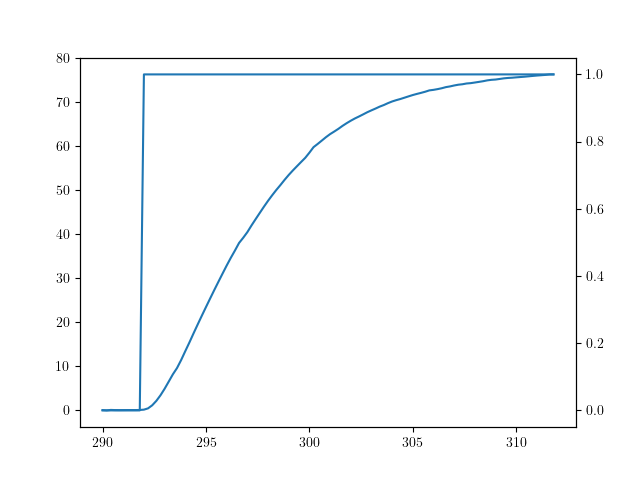

In [41]:
identif_idx = 100
fig, ax = plt.subplots(1,1)
i = 4
cart_i = ct_names.index(ct_edge_names[i])
ax.plot(t[ct_i_on[i]-10:ct_i_on[i]+identif_idx], ct_temp[cart_i, ct_i_on[i]-10:ct_i_on[i]+identif_idx] - ct_temp[cart_i, ct_i_on[i]-10])
ax2 = ax.twinx()
ax2.plot(t[ct_i_on[i]-10:ct_i_on[i]+identif_idx], ct_status[cart_i, ct_i_on[i]-10:ct_i_on[i]+identif_idx])

Model estimation using an ARX identification.

In [45]:
# identification with least square
# y = theta @ [a1,...,an, b1, ..., bn]
na = 2 # input coeff of numerator order + 1
nb = 4 # output coeff of denominator order + 1
count_none = []
for identif_idx in range(10, 400, 1):
    sys_top_stack_cart_arx_list = []
    for i in range(len(tau_063_list)):
        try:
            a_coeff, b_coeff, mse = lsq(na, nb, u=ct_status[cart_i, ct_i_on[i]-1:ct_i_on[i]+identif_idx], 
                                                y=ct_temp[cart_i, ct_i_on[i]-1:ct_i_on[i]+identif_idx] - ct_temp[cart_i, ct_i_on[i]-1], 
                                                y_init=np.zeros((nb-1,1)))
            sys_top_stack_cart_arx_list.append(ctrl.TransferFunction(a_coeff, np.insert(b_coeff, 0, 1), dt))
        except:
            sys_top_stack_cart_arx_list.append(None)
        try:
            t_sim, y_sim = ctrl.step_response(sys_top_stack_cart_arx_list[i], T=30)  
            ax[i].plot(t_sim+t[int(margin/2)], y_sim, ':', label="sim ARX")
            ax[i].legend()
        except:
            pass
    count_none.append(np.sum([1 for elem in sys_top_stack_cart_arx_list if elem is None] ))

Text(0.5, 0, 'Samples used for identification')

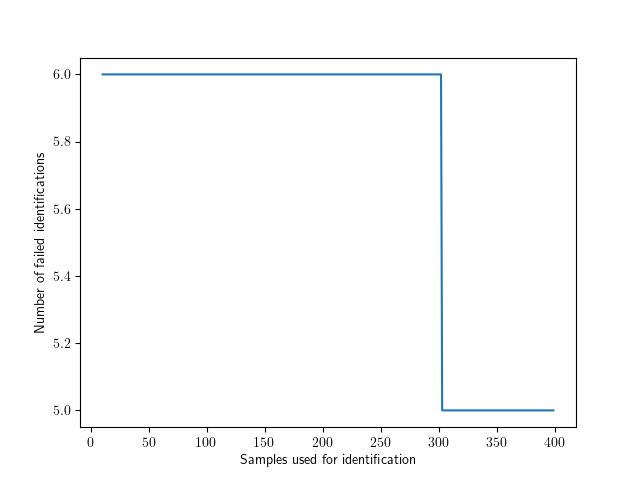

In [46]:
fig, ax = plt.subplots(1,1)
ax.plot(np.arange(10, 400, 1),count_none)
ax.set_ylabel("Number of failed identifications")
ax.set_xlabel("Samples used for identification")

In [51]:
na = 2 # input coeff of numerator order + 1
nb = 3 # output coeff of denominator order + 1
identif_idx = 400
sys_top_stack_cart_arx_list = []
for i in range(len(tau_063_list)):
    try:
        a_coeff, b_coeff, mse = lsq(na, nb, u=ct_status[cart_i, ct_i_on[i]-1:ct_i_on[i]+identif_idx], 
                                            y=ct_temp[cart_i, ct_i_on[i]-1:ct_i_on[i]+identif_idx] - ct_temp[cart_i, ct_i_on[i]-1], 
                                            y_init=np.zeros((nb-1,1)))
        sys_top_stack_cart_arx_list.append(ctrl.TransferFunction(a_coeff, np.insert(b_coeff, 0, 1), dt))
        t_sim, y_sim = ctrl.step_response(sys_top_stack_cart_arx_list[i], T=t[ct_i_off[i]]-t[ct_i_on[i]])  
        ax[i].plot(t_sim+t[int(margin/2)], y_sim, ':', label="sim ARX")
        ax[i].legend()
    except:
        sys_top_stack_cart_arx_list.append(None)
sys_top_stack_cart_arx_list

[None,
 None,
 None,
 TransferFunction(array([0.06553836, 0.409507  ]), array([ 1.        , -1.7993007 ,  0.80516736]), 0.2),
 None,
 TransferFunction(array([0.06974089, 0.30072956]), array([ 1.        , -1.82831439,  0.83287343]), 0.2),
 None,
 None,
 None]

In [99]:
from gekko import GEKKO
i = 0

t_id = t[ct_i_on[i]-10:ct_i_on[i]+identif_idx]
u_id = ct_status[cart_i, ct_i_on[i]-10:ct_i_on[i]+identif_idx]
y_id = ct_temp[cart_i, ct_i_on[i]-10:ct_i_on[i]+identif_idx] - ct_temp[cart_i, ct_i_on[i]-10]

u_id = u_id.reshape(-1,1)
y_id = y_id.reshape(-1,1)

print("shapes: {}, {}, {}".format(t_id.shape, u_id.shape, y_id.shape))

m = GEKKO()

yp,p,K = m.sysid(t_id,u_id,y_id,na,nb,diaglevel=1)

shapes: (410,), (410, 1), (410, 1)
apm 94.228.179.50_gk_model23 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.1
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            2
   Constants    :            6
   Variables    :         1240
   Intermediates:            0
   Connections  :            7
   Equations    :          821
   Residuals    :          821
 
 Number of state variables:            416
 Number of total equations: -          410
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              6
 
 **********************************************
 Model Parameter Estimation with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

**********************************************************

In [98]:
p

{'a': array([[0.02131464],
        [0.98542699]]),
 'b': array([[[0.],
         [0.],
         [0.]]]),
 'c': array([0.00394829])}

The identification with the ARX method seems to be inadequat... Let's try to filter the slow dynamic behaviour of the stack from the data.

In [56]:
top_stack_sys = ctrl.TransferFunction([0.003808, 0.007945], [1, -1.144, 0.157], dt)
top_stack_inv_sys = ctrl.TransferFunction([1, -1.144, 0.157], [0.003808, 0.007945], dt)

In [63]:
top_stack_inv_sys.den[0][0]

array([0.003808, 0.007945])

Text(0.5, 1.0, 'Filtering the stack temperature variations')

/home/vincent/miniconda3/envs/heat_reg/lib/python3.12/site-packages/matplotlib/ticker.py:2098: RuntimeWarning: overflow encountered in multiply
  steps = self._extended_steps * scale
/home/vincent/miniconda3/envs/heat_reg/lib/python3.12/site-packages/matplotlib/ticker.py:2098: RuntimeWarning: overflow encountered in multiply
  steps = self._extended_steps * scale
/home/vincent/miniconda3/envs/heat_reg/lib/python3.12/site-packages/matplotlib/ticker.py:2098: RuntimeWarning: overflow encountered in multiply
  steps = self._extended_steps * scale


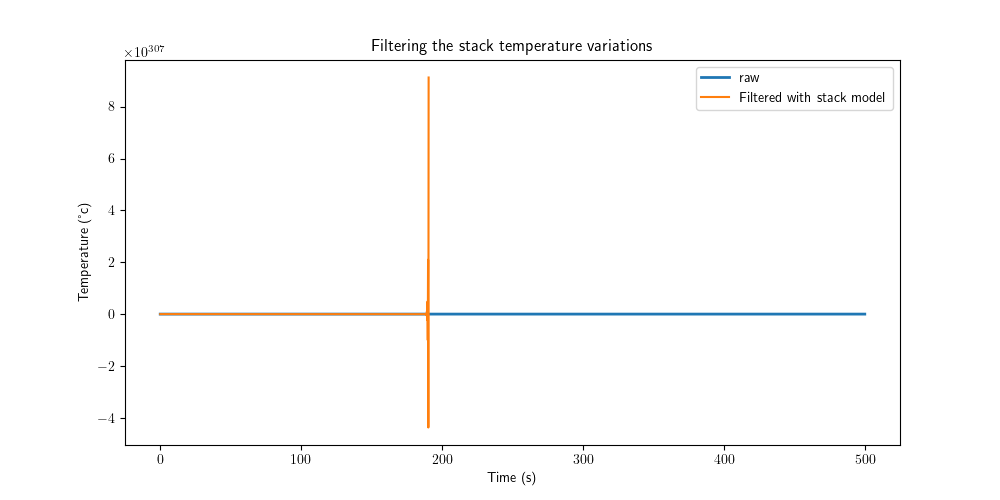

/home/vincent/miniconda3/envs/heat_reg/lib/python3.12/site-packages/matplotlib/ticker.py:2098: RuntimeWarning: overflow encountered in multiply
  steps = self._extended_steps * scale
/home/vincent/miniconda3/envs/heat_reg/lib/python3.12/site-packages/matplotlib/ticker.py:2098: RuntimeWarning: overflow encountered in multiply
  steps = self._extended_steps * scale
/home/vincent/miniconda3/envs/heat_reg/lib/python3.12/site-packages/matplotlib/ticker.py:2098: RuntimeWarning: overflow encountered in multiply
  steps = self._extended_steps * scale


In [65]:
ct_11_filtered = sig.lfilter(top_stack_inv_sys.num[0][0], top_stack_inv_sys.den[0][0], ct_temp[0])

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(t, ct_temp[0], color=color_list[0], linewidth=2, label='raw')
ax.plot(t, ct_11_filtered + ct_temp[0,0], color=color_list[1], label='Filtered with stack model')
ax.set_xlabel('Time (s)') 
ax.set_ylabel('Temperature (°c)') 
ax.legend()
ax.set_title("Filtering the stack temperature variations")

## PID Tuning

Now that we have a model for the cartridges dynamics, let's tune a PID controler to insure a stable quick response of the system.

### IMC Method

Let's use the Internal Model Control (IMC) rule for a quick tuning:
$$K_p = \frac{2\xi\omega_d}{K\omega_0}$$
$$T_i = \frac{2\xi}{\omega_0}$$
$$T_d = \frac{1}{2\xi\omega_0}$$
with $\omega_d$ a tuning parameter, it can be choosen as 10 $\omega_0$ for a very aggresive response, 1 for a moderate response or 0.1 for a conservative response.
$$C(s) = K_p \left(1 + \frac{1}{T_i s} + \frac{T_d s}{1 + \frac{T_d}{N}s}\right) $$
The PID shown here has its derivative action filtered, using the coefficient $N$ that should be between 3 and 10.

In [33]:
# continuous form of the PID
N = 10
R = 1
Kp = 2*xi_CT_11_01*R/K_CT_11*cyclic_time # 
Ti = 2*xi_CT_11_01/w0_CT_11_01
Td = 1/(2*xi_CT_11_01*w0_CT_11_01)
pid_CT_11 = ctrl.tf([Kp*Ti*Td*(1+N), Kp*(N*Ti+Td), Kp*N], [Ti*Td, N*Ti, 0])

Let's discretize this PID controller using the bilinear transform.

In [34]:
# pid_d_CT_11 = ctrl.c2d(pid_CT_11, dt, method='tustin')
perc_list = [1,0.5,0.2,0.1,0.05,0.02,0.01]
pid_d_CT_11_list = [ctrl.c2d(ii*pid_CT_11, dt, method='tustin') for ii in perc_list]

In [35]:
# close loop step response
CL_CT_11_list = [pid_d*sys2d_CT_11_01_ms/(1+pid_d*sys2d_CT_11_01_ms) for pid_d in pid_d_CT_11_list]
CL_CT_11_u_list = [pid_d/(1+pid_d*sys2d_CT_11_01_ms) for pid_d in pid_d_CT_11_list]
# CL_CT_11 = (pid_CT_11 * sys2_CT_11_01) / (1 + pid_CT_11 * sys2_CT_11_01)
# CL_CT_11_u = (pid_CT_11) / (1 + pid_CT_11 * sys2_CT_11_01)
t_sim = 100
y_CT_11_sim2_CL_list = np.zeros((int(t_sim/dt)+1, len(pid_d_CT_11_list)))
u_CT_11_sim2_CL_list = np.zeros((int(t_sim/dt)+1, len(pid_d_CT_11_list)))
for i in range(len(pid_d_CT_11_list)):
    t_CT_11_sim2_CL, y_CT_11_sim2_CL_list[:,i] = ctrl.step_response(steady_state_value_CT_11*CL_CT_11_list[i], T=t_sim)
    _, u_CT_11_sim2_CL_list[:,i] = ctrl.step_response(steady_state_value_CT_11*CL_CT_11_u_list[i], T=t_sim)
# t_CT_11_sim2_CL, y_CT_11_sim2_CL = ctrl.step_response(steady_state_value_CT_11*CL_CT_11, T=100)
# _, u_CT_11_sim2_CL = ctrl.step_response(steady_state_value_CT_11*CL_CT_11_u, T=100)

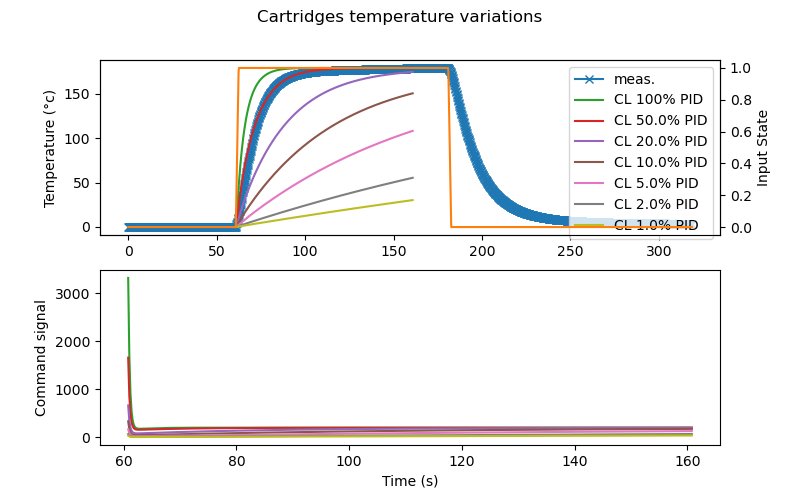

In [36]:
# Comparison of the continuous responses
fig, ax = plt.subplots(2, 1, figsize=(8, 5)) #
fig.suptitle("Cartridges temperature variations")
ax[1].set_xlabel('Time (s)') 
ax[0].set_ylabel('Temperature (°c)') 
ax[1].set_ylabel('Command signal') 

ax[0].plot(t_CT_11-t_CT_11[0], CT_11_step_response - CT_11_init_val, '-x', label='meas.')
ax2 = ax[0].twinx()
ax2.plot(t_CT_11-t_CT_11[0], CT_11_input, color=color_list[1])
ax2.set_ylabel('Input State')
for i, perc in enumerate(perc_list):
    ax[0].plot(t_CT_11_sim2_CL+t_start_CT_11-t_CT_11[0], y_CT_11_sim2_CL_list[:,i], color=color_list[2+i], label="CL "+str(100*perc)+r'% PID')

ax[0].legend()
for i, perc in enumerate(perc_list):
    ax[1].plot(t_CT_11_sim2_CL+t_start_CT_11-t_CT_11[0], u_CT_11_sim2_CL_list[:,i], color=color_list[2+i], label="CL cmd "+str(100*perc)+r'% PID')

In [37]:
print(Kp)
print(Ti)
print(Td)

2.232079959840897
10.80000000000011
2.7000000000000277


In [38]:
np.roots(np.array(sys2_CT_11_01.den).squeeze())

array([-0.18518518, -0.18518519])

### PID Tuning with PSO

In [39]:
import pyswarms as ps
from tqdm.notebook import tqdm

def simulate_PID(PID:np.array, model:ctrl.TransferFunction, t_sim:(np.array), cmd_boundaries:(np.array or None)=None, target:float=1, delta_activation:(float or None)=None):
    """
    Simulate PID controller with a given model and PID parameters.

    Args:
        PID (np.array): Concatenation of Kp, Ki, Kd for PID tuning.
        model (TransferFunction): Discrete model of the cartridge 
        t_sim (np.array): Simulation time array
        cmd_boundaries (np.array): [min, max] values of the command signal (for saturation)
        target (float): Target value (y*)
        delta_activation (float): Activation threshold for the PID

    Returns:
        y (np.array): Output array for the simulation.
        u (np.array): Command array for the simulation.
    """
    # check the input model
    if not ctrl.isdtime(model):
        raise ValueError("The system should be discrete.")
    # init
    a_coeff = np.array(model.num).squeeze()
    b_coeff = np.array(model.den).squeeze()[1:] # ignoring the higher coefficient (that should be 1)
    e = 0
    e_sum = 0
    e_last = 0
    t_last = t_sim[0]
    y_lag = np.zeros((len(a_coeff), 1))
    u_lag = np.zeros((len(b_coeff), 1))
    u = np.zeros(t_sim.shape)
    y = np.zeros(t_sim.shape)
    if cmd_boundaries is None:
        cmd_boundaries = [-np.inf, np.inf]
    u_max = cmd_boundaries[1]
    u_min = cmd_boundaries[0]
    Kp = PID[0]
    Ki = PID[1]
    Kd = PID[2]
    if delta_activation is None:
        delta_activation = np.inf
    
    for k, t in enumerate(t_sim):
        e = target - y_lag[0]
        dt = t - t_last
        t_last = t
        if e < delta_activation: # the pid is only activated for the precision
            e_sum = e_sum + e*(dt)
            if dt > 0:
                der_act = Kd*(e - e_last)/dt
            else:
                der_act = 0
            u_lag[0] = Kp*e + Ki*e_sum*dt + der_act # pid cmd
        elif not np.isinf(u_max):
            # print("delta activation effective.")
            u_lag[0] = u_max # max cmd first
        else:
            raise ValueError("If delta_activation is set to true, the boundaries should be defined for the saturation.")
            # TODO: the command value before the delta activation could be something else that the upper boundary..
        # saturation
        if (u_lag[0] > u_max):
            u_lag[0] = u_max
        elif (u_lag[0] < u_min):
            u_lag[0] = u_min
        e_last = e # previous error
        # record data
        y[k] = y_lag[0].squeeze()
        u[k] = u_lag[0].squeeze()
        # compute new y
        y_out = a_coeff@u_lag - b_coeff@y_lag # cartridge model
        u_lag = np.roll(u_lag, 1)
        y_lag = np.roll(y_lag, 1)
        y_lag[0] = y_out
    return y, u

def cost_function_PID(PID, model, cmd_boundaries):
    """
    Cost function for Particle Swarm Optimization (PSO) to tune PID controller.

    Args:
        PID (np.array): Concatenation of Kp, Ki, Kd for PID tuning.
        model (TransferFunction): Discrete model of the cartridge TODO: add StateSpace model
        cmd_boundaries (np.array): [min, max] values of the command signal (for saturation)

    Returns:
        J (list): List of cost values for each set of PID parameters.
    """
    J = []
    a_coeff = np.array(model.num).squeeze()
    b_coeff = np.array(model.den).squeeze()[1:] # ignoring the higher coefficient (that should be 1)
    dt = model.dt
    # Extract Ki, Kp and Kp gains
    Kp_param = PID[:,0]
    Ki_param = PID[:,1]
    Kd_param = PID[:,2]
    y_des = 100
    dy_thresh = 1
    du_thresh = 20
    t_sim = np.arange(0, 60, dt)
    for Kp, Ki, Kd in zip(Kp_param, Ki_param, Kd_param):
        # simulate closed-loop output using ARX modelisation
        e = 0 # e = y* - y
        e_sum = 0
        y_lag = np.zeros((2, 1))
        u_lag = np.zeros((2, 1))
        u = np.zeros(t_sim.shape)
        y = np.zeros(t_sim.shape)
        for k, t in enumerate(t_sim):
            e = y_des - y_lag[0]
            if e < 20: # the pid is only activated for the precision
                e_sum = e_sum + e*(dt)
                u_lag[0] = Kp*e + Ki*e_sum*dt + Kd*(e - e_last)/(dt) # pid cmd
            else:
                u_lag[0] = 200 # max cmd first
            # saturation
            if (u_lag[0] > cmd_boundaries[1]):
                u_lag[0] = cmd_boundaries[1]
            elif (u_lag[0] < cmd_boundaries[0]):
                u_lag[0] = cmd_boundaries[0]
            e_last = e # previous error
            # record data
            y[k] = y_lag[0].squeeze()
            u[k] = u_lag[0].squeeze()
            # compute new y
            y_out = a_coeff@u_lag - b_coeff@y_lag # cartridge model
            u_lag = np.roll(u_lag, 1)
            y_lag = np.roll(y_lag, 1)
            y_lag[0] = y_out

        # # Computing the 5% settling time and max cmd value
        settling_time = t_sim[-1]
        for k, t in enumerate(np.flip(t_sim)):
            if abs(y[-1-k] - y_des) >= 0.05*y_des:
                settling_time = t
                break # last time the settling time is reached
        max_out_val = max(y)
        # first time reaching tresh
        try:
            t_y_thresh_first = t_sim[np.where((y_des - y) < 0.05*y_des)[0][0]]
        except:
            t_y_thresh_first = 2*t_sim[-1] # target never reached...
        # check stability of both the command and output
        dy = np.gradient(y, t_sim)
        du = np.gradient(u, t_sim)
        # y stability
        y_thresh_mask = dy < dy_thresh
        y_false_mask = dy > dy_thresh
        y_false_mask[1:] = y_false_mask[:-1]
        lasts_false = y_thresh_mask & y_false_mask  
        try:
            t_y_thresh_last = t_sim[lasts_false]
            if isinstance(t_y_thresh_last, np.ndarray):
                t_y_thresh_last = t_y_thresh_last[-1]
        # u stability
        except:
            t_y_thresh_last = 2*t_sim[-1] # not stable
            u_thresh_mask = du < du_thresh
            u_false_mask = du > du_thresh
            u_false_mask[1:] = u_false_mask[:-1]
            lasts_false = u_thresh_mask & u_false_mask
        try:
            t_u_thresh_last = t_sim[lasts_false]
            if isinstance(t_u_thresh_last, np.ndarray):
                t_u_thresh_last = t_u_thresh_last[-1]
        except:
            t_u_thresh_last = 2*t_sim[-1] # not stable


        # cost function that penalize overshoot, settling time and important gains
        # J.append(settling_time/10 + 1.2*max_out_val/y_des + (Kp+Ki+Kd)/100)
        score = t_y_thresh_last/15 + t_u_thresh_last/30 + t_y_thresh_first/10 + max_out_val/y_des + np.abs(e)
        J.append(score[0])
    return J

def tune_PID_with_PSO(sys:ctrl.TransferFunction, u_lim:(np.array or None)=None, verbose:bool=True):
    """
    Tune the PID controler using a PSO to achieve the quickest response.
    If a state space system is provided, then the second state should be the output.

    Args:
        sys (TransferFunction or StateSpace): Second-order system model.
        u_lim (np.array or None): Boundaries of the cmd signal.
                              If None, no limitation is set on the control signal.
        verbose (bool): If True, display optimization progress; default is True.
    Returns:
        PID (np.array): The tuned PID gains (Kp, Ki, Kd).
    """
    # Check the system type
    if not isinstance(sys, ctrl.TransferFunction):
        raise ValueError("Unsupported system type: {}".format(type(sys)))
    # Check if the system is discrete
    if not ctrl.isdtime(sys):
        raise ValueError("The system should be discrete.")
    else:
        dt = sys.dt
    dim = 3 # (Kp, Ki, Kd)
    max_bound = 10000 * np.ones(dim) 
    min_bound = 0 * np.ones(dim)
    bounds = (min_bound, max_bound)
    cmd_bounds = np.array([0, 200]) # response comprised between 0ms and 200ms
    options = {'c1': 0.5, 'c2': 0.3, 'w':0.9}
    kwargs={'model':sys, 'cmd_boundaries': cmd_bounds}
    optimizer = ps.single.GlobalBestPSO(n_particles=30, dimensions=dim, ftol = 1e-3, ftol_iter = 30, options=options, bounds=bounds)
    cost, PID_gains = optimizer.optimize(cost_function_PID, 100, n_processes=10, verbose=verbose,**kwargs)

    return PID_gains, cost

In [40]:
pid_gains, cost = tune_PID_with_PSO(sys2d_CT_11_01_ms, np.array([0, 200]))

2024-03-13 13:40:28,794 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:  51%|█████     |51/100, best_cost=3.09
2024-03-13 13:40:32,682 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 3.0889147554506113, best pos: [8296.23108464 1547.30574541 8664.31419596]


In [64]:
%%time
# Uncomment this cell to rerun PSO optimization
niter = 1000
# PID_list = np.zeros((niter, 3))
# t_settling_list = np.zeros(niter)
# cost_list = np.zeros(niter)
# u_max_list = np.zeros(niter)
# for i in tqdm(range(niter)):
#     PID_list[i,:], cost_list[i] = tune_PID_with_PSO(sys2d_CT_11_01_ms, np.array([0, 200]))

  0%|          | 0/1000 [00:00<?, ?it/s]

2024-03-04 15:07:09,328 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:  88%|████████▊ |88/100, best_cost=3.08
2024-03-04 15:07:15,066 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 3.08437128666535, best pos: [5958.0969868   265.96394594 6176.35176437]
2024-03-04 15:07:15,093 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:  43%|████▎     |43/100, best_cost=3.09
2024-03-04 15:07:18,198 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 3.088350327603254, best pos: [6416.86813543 1112.52262001 6178.27116846]
2024-03-04 15:07:18,230 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:  43%|████▎     |43/100, best_cost=3.08
2024-03-04 15:07:22,522 - pyswarms.single.global_best - INFO - Optimization finishe

CPU times: user 10min 21s, sys: 6min 7s, total: 16min 28s
Wall time: 1h 39min


In [65]:
# save PID list and cost in a csv file
data = np.hstack((PID_list, cost_list.reshape(len(cost_list),1)))
np.savetxt('PID_list_PSO_optimization_24_03_04.csv', data, delimiter=',', header='Kp,Ki,Kd,cost')

In [66]:
# simulate PID response of each optimization, and save sme in pdf files
t_sim = np.arange(0, 60, dt)
for i in tqdm(range(niter)):
    y, u = simulate_PID(PID_list[i,:], sys2d_CT_11_01_ms, t_sim, cmd_boundaries=np.array([0, 200]), target=100)
    fig, ax = plt.subplots(1, 1, constrained_layout=True)
    ax.plot(t_sim, y, label='y')
    ax2 = ax.twinx()
    ax2.plot(t_sim, u, 'rx-', label='cmd')
    ax.plot(t_sim, 100*np.ones(t_sim.shape), 'k--')
    ax.set_xlabel('Time (s)') 
    ax.set_ylabel('Temperature (°c)') 
    ax2.set_ylabel('Time On (ms)') 
    fig.suptitle('PID simulation : (Kp, Ki, Kd) = ({:.4f}, {:.4f}, {:.4f})'.format(PID_list[i,0],PID_list[i,1],PID_list[i,2]), fontsize=12)
    fig.legend()
    fig.savefig('misc/pid_plots_v2/PID_response_{}.pdf'.format(i))


  0%|          | 0/1000 [00:00<?, ?it/s]

/tmp/ipykernel_5713/3151651874.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1, 1, constrained_layout=True)


In [53]:
# read the data from the saved csv
PID_list = np.genfromtxt('PID_list_PSO_optimization.csv', delimiter=',')
cost_list = PID_list[:,3]
n = np.argmin(cost_list)
dt = 2e-1
PID_list[n,:]

array([16.37006826,  3.35068001, 20.3451225 ,  2.1342441 ])

In [61]:
# simulate close loop with the tuned PID
t_sim = np.arange(0, 100, dt)
y_des = 20
e = 0 # e = y* - y
e_sum = 0
e_last = 0
y_lag = np.zeros((2, 1))
u_lag = np.zeros((2, 1))
u = np.zeros(t_sim.shape)
y = np.zeros(t_sim.shape)
# Kp = PID_list[n,0]
# Ki = PID_list[n,1]
# Kd = PID_list[n,2]
Kp = pid_gains[0]
Ki = pid_gains[1]
Kd = pid_gains[2]
cmd_boundaries = np.array([0, 200])
a_coeff = np.array(sys2d_CT_11_01_ms.num).squeeze()
b_coeff = np.array(sys2d_CT_11_01_ms.den).squeeze()[1:]

for k, t in enumerate(t_sim):
    e = y_des - y_lag[0]
    if e < 20: # the pid is only activated for the precision
        e_sum = e_sum + e*(dt)
        int_act = Ki*e_sum*dt
        if dt > 0:
            der_act = Kd*(e - e_last)/dt
        else:
            der_act = 0
        u_lag[0] = Kp*e + int_act + der_act # pid cmd
    else:
        u_lag[0] = 200 # max cmd first
    # saturation
    if (u_lag[0] > cmd_boundaries[1]):
        u_lag[0] = cmd_boundaries[1]
    elif (u_lag[0] < cmd_boundaries[0]):
        u_lag[0] = cmd_boundaries[0]
    e_last = e # previous error
    # record data
    y[k] = y_lag[0].squeeze()
    u[k] = u_lag[0].squeeze()
    # compute new y
    y_out = a_coeff@u_lag - b_coeff@y_lag # cartridge model
    u_lag = np.roll(u_lag, 1)
    y_lag = np.roll(y_lag, 1)
    y_lag[0] = y_out

In [64]:
Kp

16.37006826416973

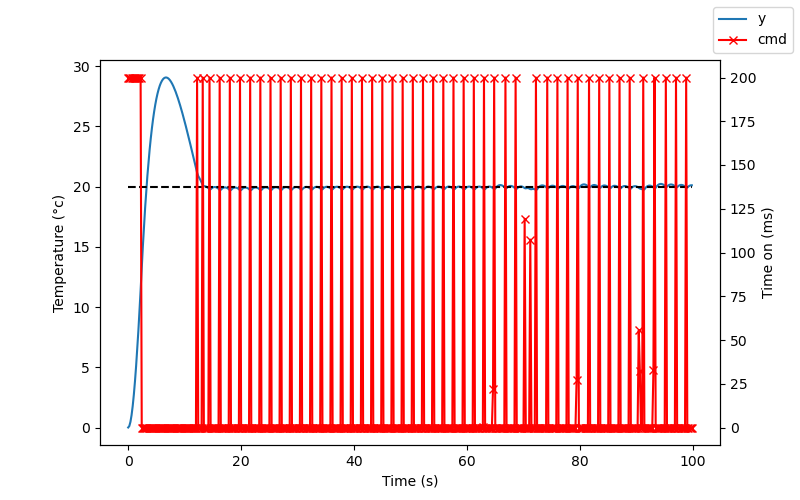

In [62]:
# plot the results
fig, ax = plt.subplots(1,1,figsize=(8, 5)) #
ax.plot(t_sim, y, label='y')
ax2 = ax.twinx()
ax2.plot(t_sim, u, 'rx-', label='cmd')
ax.plot(t_sim, y_des*np.ones(t_sim.shape), 'k--')
ax.set_xlabel('Time (s)') 
ax.set_ylabel('Temperature (°c)') 
ax2.set_ylabel('Time on (ms)') 
fig.legend()

In [57]:
PID_list[n,0:3]

array([16.37006826,  3.35068001, 20.3451225 ])

In [78]:
y_sim, u_sim = simulate_PID(PID_list[n,0:3], sys2d_CT_11_01_ms, np.arange(0,100,dt), [0,200], 20)


[0.00059959 0.00058497]
[-1.92728089  0.92860291]


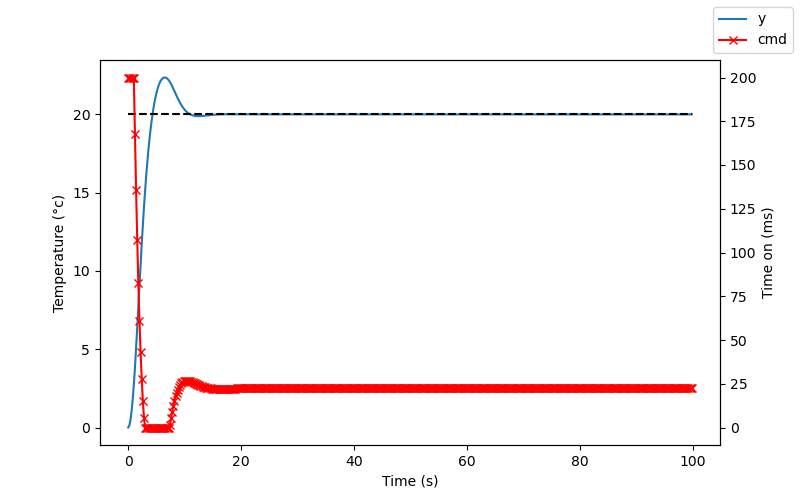

In [79]:
# plot the results
fig, ax = plt.subplots(1,1,figsize=(8, 5)) #
ax.plot(np.arange(0,100,dt), y_sim, label='y')
ax2 = ax.twinx()
ax2.plot(np.arange(0,100,dt), u_sim, 'rx-', label='cmd')
ax.plot(np.arange(0,100,dt), 20*np.ones(np.arange(0,100,dt).shape), 'k--')
ax.set_xlabel('Time (s)') 
ax.set_ylabel('Temperature (°c)') 
ax2.set_ylabel('Time on (ms)') 
fig.legend()